In [1]:
import sys
# import comet_ml
import torch

import numpy as np

from sklearn.metrics import (
    f1_score, confusion_matrix, classification_report,
    balanced_accuracy_score, accuracy_score,
)
# from transformers.integrations import CometCallback

sys.path.append('..')
from lib.utils import set_seed, get_device
from lib.utils.constants import RANDOM_SEED
from lib.data.loading import pd_read_jsonl_file

In [2]:
import os
# from dotenv import load_dotenv

# load_dotenv()

# comet_api_key = os.getenv("COMET_API_KEY")

os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [3]:
import torch

torch.cuda.empty_cache()

In [4]:
set_seed(RANDOM_SEED)

DEVICE = get_device()
print(f'Using device: {DEVICE}')

Using device: cuda


In [5]:
df_en_train = pd_read_jsonl_file('../data/multilingual_train.jsonl')
df_en_dev = pd_read_jsonl_file('../data/multilingual_dev.jsonl')
df_en_test = pd_read_jsonl_file('../data/multilingual_devtest_text_id_only.jsonl')

In [6]:
df_en_train['label'].value_counts(normalize=True)

label
1    0.617305
0    0.382695
Name: proportion, dtype: float64

In [7]:
df_en_dev['label'].value_counts(normalize=True)

label
1    0.618663
0    0.381337
Name: proportion, dtype: float64

In [6]:
import pandas as pd

# Separate the DataFrame into two based on the label values
df_en_train_label_1 = df_en_train[df_en_train['label'] == 1]
df_en_train_label_0 = df_en_train[df_en_train['label'] == 0]

# Determine the smaller count between the two labels
min_count = min(len(df_en_train_label_1), len(df_en_train_label_0))

# Sample the same number of rows from both DataFrames
df_en_train_label_1_sampled = df_en_train_label_1.sample(n=min_count, random_state=RANDOM_SEED)
df_en_train_label_0_sampled = df_en_train_label_0.sample(n=min_count, random_state=RANDOM_SEED)

# Concatenate the sampled DataFrames to create a new DataFrame with a balanced label distribution
df_en_train = pd.concat([df_en_train_label_1_sampled, df_en_train_label_0_sampled])

# Shuffle the new DataFrame to mix the labels
df_en_train = df_en_train.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

In [8]:
# Remove generated samples from english such that we have a balanced dataset over the label distribution

# Rebalance the multilingual_train dataset by downsampling the majority class (label 0) to the minority class (label 1) removing only from the english language

# Get the number of samples for each language
n_samples_per_lang = df_en_train['lang'].value_counts()

# Get the number of samples for each language and label
n_samples_per_lang_label = df_en_train.groupby(['lang', 'label']).size().unstack().fillna(0)

# Remove samples from the english language with label 1 to have in total the same number of samples 0 and 1 in the final dataset
n_samples_per_lang_label['diff'] = n_samples_per_lang_label[1] - n_samples_per_lang_label[0]

for lang, diff in n_samples_per_lang_label['diff'].items():
    if lang == 'en':
        df_en_train = df_en_train.drop(
            df_en_train[
                (df_en_train['lang'] == lang) & (df_en_train['label'] == 1)
            ].sample(int(diff)).index
        )

df_en_train['label'].value_counts(normalize=True)

label
1    0.505643
0    0.494357
Name: proportion, dtype: float64

In [6]:
# Create a new df with all non-english samples
df_non_en_train = df_en_train[df_en_train['lang'] != 'en']
df_non_en_train['label'].value_counts(normalize=True)

label
1    0.546438
0    0.453562
Name: proportion, dtype: float64

In [7]:
# Create a new df with all non-english samples
df_non_en_dev = df_en_dev[df_en_dev['lang'] != 'en']
df_non_en_dev['label'].value_counts(normalize=True)

label
1    0.551673
0    0.448327
Name: proportion, dtype: float64

In [6]:
df_en_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 674083 entries, 0 to 674082
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          674083 non-null  object
 1   source      674083 non-null  object
 2   sub_source  674083 non-null  object
 3   lang        674083 non-null  object
 4   model       674083 non-null  object
 5   label       674083 non-null  int64 
 6   text        674083 non-null  object
dtypes: int64(1), object(6)
memory usage: 36.0+ MB


In [7]:
df_en_train.head()

,id,source,sub_source,lang,model,label,text
0,808a846d-41c1-46ff-80ab-892b01bec5f3,m4gt,arxiv,en,gemma-7b-it,1,This report summarizes the findings of the US ...
1,673ec6fc-624a-4ad5-8d5f-a5950b0e5432,mage,wp,en,human,0,I've been standing here for days now. Watching...
2,3059e6e4-1724-4745-a833-cbb6bfb4acd8,mage,xsum,en,flan_t5_xl,1,"Towell, 25, was knocked down twice during the ..."
3,4ca1cde7-6dbd-4519-b60c-7f8c8fcd0d36,hc3,open_qa,zh,gpt-35,1,我不确定你想要问的是什么，但是阿玛尼是一个奢侈品牌，它的产品包括化妆品、香水和时装。黑手党是...
4,f9cca231-ed31-45a9-a448-99245f72e32c,hc3,reddit_eli5,en,gpt-35,1,"Sometimes when we eat certain types of food, o..."


In [8]:
MODEL_NAME = "FacebookAI/xlm-roberta-base"

In [9]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

/root/.conda/envs/pytorch/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [10]:
# Count the number of tokens in each sentence
df_en_train['num_tokens'] = df_en_train['text'].apply(lambda x: len(tokenizer(x)['input_ids']))
df_en_dev['num_tokens'] = df_en_dev['text'].apply(lambda x: len(tokenizer(x)['input_ids']))
df_en_test['num_tokens'] = df_en_test['text'].apply(lambda x: len(tokenizer(x)['input_ids']))

Token indices sequence length is longer than the specified maximum sequence length for this model (712 > 512). Running this sequence through the model will result in indexing errors


In [11]:
df_en_train['num_tokens'].describe()

count    674083.000000
mean        341.414615
std         334.816559
min           2.000000
25%         121.000000
50%         265.000000
75%         451.000000
max        6057.000000
Name: num_tokens, dtype: float64

In [12]:
df_en_dev['num_tokens'].describe()

count    288894.000000
mean        342.691181
std         337.013863
min           2.000000
25%         121.000000
50%         266.000000
75%         453.000000
max        5574.000000
Name: num_tokens, dtype: float64

In [13]:
df_en_test['num_tokens'].describe()

count    74081.000000
mean       226.702245
std        128.692411
min          8.000000
25%        123.000000
50%        216.000000
75%        310.000000
max        852.000000
Name: num_tokens, dtype: float64

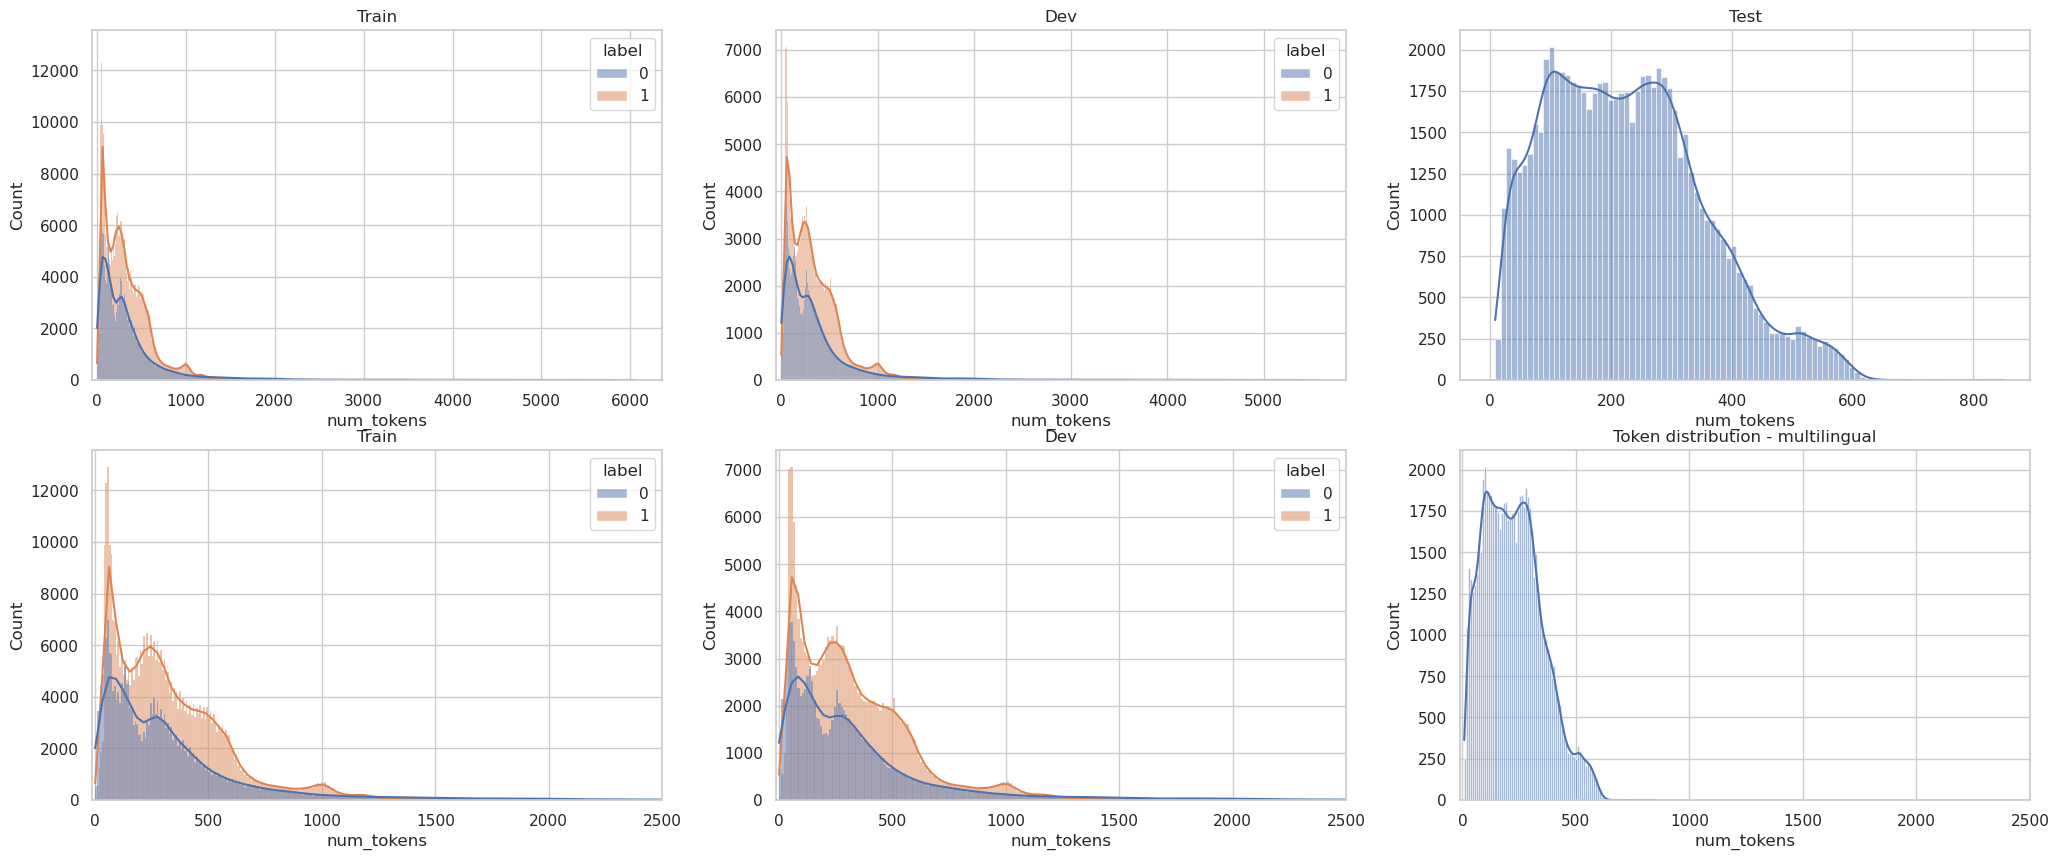

In [14]:
# Create a distribution plot over the number of tokens grouped by dataset and label
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

fig, ax = plt.subplots(2, 3, figsize=(25, 10))

sns.histplot(df_en_train, x='num_tokens', hue='label', kde=True, ax=ax[0][0])
sns.histplot(df_en_dev, x='num_tokens', hue='label', kde=True, ax=ax[0][1])
sns.histplot(df_en_test, x='num_tokens', kde=True, ax=ax[0][2])

sns.histplot(df_en_train, x='num_tokens', hue='label', kde=True, ax=ax[1][0])
sns.histplot(df_en_dev, x='num_tokens', hue='label', kde=True, ax=ax[1][1])
sns.histplot(df_en_test, x='num_tokens', kde=True, ax=ax[1][2])

ax[0][0].set_title('Train')
ax[0][0].set_xlim(left=-50)
ax[0][1].set_title('Dev')
ax[0][1].set_xlim(left=-50)
ax[0][2].set_title('Test')
ax[0][2].set_xlim(left=-50)

ax[1][0].set_title('Train')
ax[1][0].set_xlim(left=-10, right=2500)
ax[1][1].set_title('Dev')
ax[1][1].set_xlim(left=-10, right=2500)
ax[1][2].set_title('Test')
ax[1][2].set_xlim(left=-10, right=2500)

plt.title("Token distribution - multilingual")
plt.show()

In [15]:
MODEL_NAME

'FacebookAI/xlm-roberta-base'

# Load model

In [17]:
MODEL_NAME = "FacebookAI/xlm-roberta-base"
FINE_TUNED_MODEL_NAME = f"../results/subtask_b/{MODEL_NAME}/001/fine-tuned-model"

In [18]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# tokenizer.truncation_side = "left"  # Truncate the beginning of the sequence

model = AutoModelForSequenceClassification.from_pretrained(FINE_TUNED_MODEL_NAME, num_labels=2)

/root/.conda/envs/pytorch/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
model

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768,

In [11]:
from peft import LoraConfig, get_peft_model

peft_config = LoraConfig(task_type="SEQ_CLS", inference_mode=False, r=4, lora_alpha=8, lora_dropout=0.25)
peft_model = get_peft_model(model, peft_config)

In [12]:
print('PEFT Model')
peft_model.print_trainable_parameters()

PEFT Model
trainable params: 739,586 || all params: 278,784,772 || trainable%: 0.2653


# Measure performance before training/fine-tuning the model

In [ ]:
import torch

from tqdm import tqdm


def get_performance_metrics(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred)

    return {
        'f1': f1,
        'accuracy': acc,
        'balanced_accuracy': bal_acc,
        'confusion_matrix': cm,
        'classification_report': cr
    }


def measure_initial_performance(model, tokenizer, df_test, device, max_length=512, batch_size=64):
    model.to(device)
    model.eval()

    test_samples = df_test.text.tolist()

    outputs = []
    for i in tqdm(range(0, len(test_samples), batch_size)):
        batch = test_samples[i:i + batch_size]
        inputs = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            output = model(**inputs)
            outputs.append(output.logits)

    outputs = torch.cat(outputs, dim=0)
    predictions = torch.argmax(outputs, dim=1).cpu().numpy()

    performance = get_performance_metrics(df_test.label, predictions)
    return performance


initial_performance = measure_initial_performance(model, tokenizer, df_en_dev, DEVICE)
initial_performance

In [11]:
def test_samples(model, tokenizer, df, device, max_length=512):
    model.to(device)
    model.eval()

    test_samples = df.text.tolist()[:5]
    inputs = tokenizer(
        test_samples,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs).logits

    # print(outputs.shape)
    print(outputs)

In [12]:
test_samples(model, tokenizer, df_en_train, DEVICE)

tensor([[-0.0314,  0.0181],
        [-0.0319,  0.0190],
        [-0.0338,  0.0227],
        [-0.0318,  0.0197],
        [-0.0323,  0.0195]], device='cuda:0')


# Fine-tune the model

In [13]:
class_weights = (
    1 / df_en_train.label.value_counts(normalize=True).sort_index()
).tolist()
class_weights = torch.tensor(class_weights)
class_weights = class_weights / class_weights.sum()

class_weights

tensor([0.6173, 0.3827])

In [14]:
non_en_class_weights = (
    1 / df_non_en_train.label.value_counts(normalize=True).sort_index()
).tolist()
non_en_class_weights = torch.tensor(non_en_class_weights)
non_en_class_weights = non_en_class_weights / non_en_class_weights.sum()

non_en_class_weights

tensor([0.5464, 0.4536])

In [15]:
from datasets import Dataset, DatasetDict

ds_train = Dataset.from_pandas(df_en_train)
ds_dev = Dataset.from_pandas(df_en_dev)
ds_test = Dataset.from_pandas(df_en_test)

/root/.conda/envs/pytorch/lib/python3.11/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [16]:
ds_train

Dataset({
    features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text'],
    num_rows: 674083
})

In [17]:
ds_train_shuffled = ds_train.shuffle(seed=RANDOM_SEED)

In [18]:
dataset = DatasetDict({
    'train': ds_train_shuffled,
    'dev': ds_dev,
    'test': ds_test
})

In [19]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text'],
        num_rows: 674083
    })
    dev: Dataset({
        features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text'],
        num_rows: 288894
    })
    test: Dataset({
        features: ['id', 'lang', 'text'],
        num_rows: 74081
    })
})

In [20]:
from datasets import Dataset, DatasetDict

ds_non_en_train = Dataset.from_pandas(df_non_en_train)
ds_non_en_dev = Dataset.from_pandas(df_non_en_dev)

In [21]:
ds_non_en_train_shuffled = ds_non_en_train.shuffle(seed=RANDOM_SEED)

In [22]:
dataset_non_en = DatasetDict({
    'train': ds_non_en_train_shuffled,
    'dev': ds_non_en_dev,
})

In [23]:
dataset_non_en

DatasetDict({
    train: Dataset({
        features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text', '__index_level_0__'],
        num_rows: 63407
    })
    dev: Dataset({
        features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text', '__index_level_0__'],
        num_rows: 27045
    })
})

In [24]:
MAX_LEN = 512
# col_to_delete = ['source', 'sub_source', 'lang', 'model']


def preprocess_dataset(ds):
    return tokenizer(ds['text'], truncation=True, max_length=MAX_LEN)


tokenized_datasets = dataset.map(preprocess_dataset, batched=True)
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/674083 [00:00<?, ? examples/s]

Map:   0%|          | 0/288894 [00:00<?, ? examples/s]

Map:   0%|          | 0/74081 [00:00<?, ? examples/s]

In [25]:
tokenized_datasets_non_en = dataset_non_en.map(preprocess_dataset, batched=True)
tokenized_datasets_non_en.set_format("torch")

Map:   0%|          | 0/63407 [00:00<?, ? examples/s]

Map:   0%|          | 0/27045 [00:00<?, ? examples/s]

In [26]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 674083
    })
    dev: Dataset({
        features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 288894
    })
    test: Dataset({
        features: ['id', 'lang', 'text', 'input_ids', 'attention_mask'],
        num_rows: 74081
    })
})

In [27]:
tokenized_datasets_non_en

DatasetDict({
    train: Dataset({
        features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 63407
    })
    dev: Dataset({
        features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 27045
    })
})

In [28]:
from transformers import DataCollatorWithPadding

collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)

In [29]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return {
        'macro_f1': f1_score(predictions, labels, average='macro'),
        'accuracy': accuracy_score(predictions,labels),
        'balanced_accuracy': balanced_accuracy_score(predictions, labels),
    }

In [30]:
import torch
import torch.nn.functional as F

from transformers import Trainer


class WeightedCrossEntropyTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        if class_weights is not None:
            self.class_weights = torch.tensor(
                class_weights, dtype=torch.float32
        ).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False):
        # Extract labels and convert them to long type for cross_entropy
        labels = inputs.pop("labels").long()

        # Forward pass
        outputs = model(**inputs)

        # Extract logits assuming they are directly outputted by the model
        logits = outputs.get('logits')

        # Compute custom loss with class weights for imbalanced data handling
        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [31]:
# from comet_ml import Experiment
# from comet_ml.integration.pytorch import log_model

# experiment = Experiment(
#     api_key=comet_api_key,
#     project_name="mgt-detection-coling-2025",
#     workspace="unibuc-phd",
# )

In [31]:
non_en_params = {
    "learning_rate": 1e-5,
    "num_train_epochs": 3,
    "weight_decay": 2e-2,
    "batch_size": 8,
    "seed": RANDOM_SEED,
}

In [32]:
non_en_total_steps = (len(tokenized_datasets_non_en["train"]) // non_en_params["batch_size"]) * non_en_params["num_train_epochs"]
non_en_warmup_steps = int(0.1 * non_en_total_steps)

In [33]:
non_en_params["warmup_steps"] = non_en_warmup_steps
non_en_warmup_steps

2377

In [34]:
from transformers import TrainingArguments

non_en_training_args = TrainingArguments(
    output_dir=f"../results/subtask_b/{MODEL_NAME}/001",
    learning_rate=non_en_params["learning_rate"],
    per_device_train_batch_size=non_en_params["batch_size"],
    per_device_eval_batch_size=non_en_params["batch_size"],
    num_train_epochs=non_en_params["num_train_epochs"],
    warmup_steps=non_en_params["warmup_steps"],
    weight_decay=non_en_params["weight_decay"],
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    seed=non_en_params["seed"],
)

comet_ml version 3.39.0 is installed, but version 3.43.2 or higher is required. Please update comet_ml to the latest version to enable Comet logging with pip install 'comet-ml>=3.43.2'.


In [35]:
non_en_trainer = WeightedCrossEntropyTrainer(
    model=peft_model,
    args=non_en_training_args,
    train_dataset=tokenized_datasets_non_en['train'],
    eval_dataset=tokenized_datasets_non_en['dev'],
    tokenizer=tokenizer,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    class_weights=non_en_class_weights,
    # callbacks=[CometCallback()],
)

/tmp/ipykernel_405330/3314886341.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(


In [36]:
non_en_train_result = non_en_trainer.train()

[2024-10-28 20:52:47,711] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: teodormarchitan (unibuc-nlp). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Balanced Accuracy
1,0.293400,0.422423,0.863499,0.869588,0.893120
2,0.202200,0.485133,0.877384,0.882529,0.904676
3,0.195900,0.533327,0.876553,0.881901,0.905431


In [ ]:
non_en_trainer.save_model(f"../results/subtask_b/{MODEL_NAME}/001/non_en-fine-tuned-model")

In [37]:
import json

with open(f"../results/subtask_b/{MODEL_NAME}/001/config_non_en.json", "w") as f:
    json.dump(non_en_params, f)

In [38]:
params = {
    "learning_rate": 5e-5,
    "num_train_epochs": 1,
    "weight_decay": 2e-2,
    "batch_size": 16,
    "seed": RANDOM_SEED,
}

# experiment.log_parameters(params)

In [39]:
en_total_steps = (len(tokenized_datasets["train"]) // params["batch_size"]) * params["num_train_epochs"]
en_warmup_steps = int(0.1 * en_total_steps)

In [40]:
params["warmup_steps"] = en_warmup_steps
en_warmup_steps

4213

In [41]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=f"../results/subtask_b/{MODEL_NAME}/001",
    learning_rate=params["learning_rate"],
    per_device_train_batch_size=params["batch_size"],
    per_device_eval_batch_size=params["batch_size"],
    num_train_epochs=params["num_train_epochs"],
    warmup_steps=params["warmup_steps"],
    weight_decay=params["weight_decay"],
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    seed=params["seed"],
)

comet_ml version 3.39.0 is installed, but version 3.43.2 or higher is required. Please update comet_ml to the latest version to enable Comet logging with pip install 'comet-ml>=3.43.2'.


In [42]:
trainer = WeightedCrossEntropyTrainer(
    model=peft_model,  # This should hold the updated model from the previous stage
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['dev'],
    tokenizer=tokenizer,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
    # callbacks=[CometCallback()],
)

/tmp/ipykernel_405330/3314886341.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(


In [43]:
train_result = trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Balanced Accuracy
1,0.200000,0.692140,0.810055,0.836681,0.873767


In [ ]:
trainer.evaluate()

In [44]:
metrics = train_result.metrics
max_train_samples = len(ds_train)
metrics["train_samples"] = min(max_train_samples, len(ds_train))
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =         1.0
  total_flos               = 166591902GF
  train_loss               =      0.2888
  train_runtime            =  2:33:24.67
  train_samples            =      674083
  train_samples_per_second =      73.233
  train_steps_per_second   =       2.289


In [45]:
trainer.save_model(f"../results/subtask_b/{MODEL_NAME}/001/fine-tuned-model")

In [46]:
import pandas as pd
from tqdm import tqdm


def make_predictions(model, tokenizer, df, device, file_path, max_len=MAX_LEN, batch_size=32):
    model.eval()

    all_ids = []
    all_predictions = []
    with torch.no_grad():
        for i in tqdm(range(0, len(df), batch_size)):
            ids = df[i:i + batch_size].id.tolist()
            texts = df[i:i + batch_size].text.tolist()

            inputs = tokenizer(texts, truncation=True, padding=True, max_length=max_len, return_tensors="pt")
            
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask).logits
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            all_ids.extend(ids)
            all_predictions.extend(preds)

    df_predictions = pd.DataFrame({
        "id": all_ids,
        "label": all_predictions,
    })

    df_predictions.to_json(
        file_path,
        orient="records",
        lines=True,
    )

    return df_predictions
    

In [47]:
df_test_predictions = make_predictions(
    trainer.model,  # Could also use peft_model ?
    tokenizer,
    df_en_test,
    DEVICE,
    f"../results/subtask_b/{MODEL_NAME}/001/subtask_b.jsonl",
)

100%|██████████| 2316/2316 [05:52<00:00,  6.56it/s]


In [48]:
df_en_train.label.value_counts(normalize=True)

label
1    0.617305
0    0.382695
Name: proportion, dtype: float64

In [49]:
df_test_predictions.label.value_counts(normalize=True)

label
1    0.895385
0    0.104615
Name: proportion, dtype: float64

In [50]:
import json

with open(f"../results/subtask_b/{MODEL_NAME}/001/config_en.json", "w") as f:
    json.dump(params, f)

In [38]:
# experiment.end()

# Make test predictions

In [19]:
MAX_LEN = 512

In [20]:
model.to(DEVICE)

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): lora.Linear(
                (base_layer): Linear(in_features=768, out_features=768, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.25, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=768, out_features=4, bias=False)
                )
                (lora_B):

In [21]:
import pandas as pd
from tqdm import tqdm


def make_test_set_predictions(model, tokenizer, df, device, file_path, max_len=MAX_LEN, batch_size=32):
    model.eval()

    all_ids = []
    all_predictions = []
    with torch.no_grad():
        for i in tqdm(range(0, len(df), batch_size)):
            ids = df[i:i + batch_size].testset_id.tolist()
            texts = df[i:i + batch_size].text.tolist()

            inputs = tokenizer(texts, truncation=True, padding=True, max_length=max_len, return_tensors="pt")

            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask).logits
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            all_ids.extend(ids)
            all_predictions.extend(preds)

    df_predictions = pd.DataFrame({
#         "id": all_ids,
        "testset_id": all_ids,
        "label": all_predictions,
    })

    df_predictions.to_json(
        file_path,
        orient="records",
        lines=True,
    )

    return df_predictions
    

In [8]:
df_en_test = pd_read_jsonl_file('../data/test_set_multilingual.jsonl')

In [9]:
df_en_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151425 entries, 0 to 151424
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   testset_id  151425 non-null  int64 
 1   text        151425 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [12]:
from tqdm import tqdm

for i in tqdm(range(len(df_en_test))):
    try:
        text = df_en_test.text.tolist()[i]
        temp_inputs = tokenizer([text], truncation=True, padding=True, max_length=MAX_LEN, return_tensors="pt")
    except Exception as e:
        print(i, text)

100%|██████████| 151425/151425 [08:36<00:00, 292.94it/s]


In [22]:
MODEL_NAME

'FacebookAI/xlm-roberta-base'

In [ ]:
df_test_predictions = make_test_set_predictions(
    model,
    tokenizer,
    df_en_test,
    DEVICE,
    f"../results/subtask_b/{MODEL_NAME}/001/test_set/subtask_b.jsonl",
)

 98%|█████████▊| 4653/4733 [12:57<00:13,  5.98it/s]

In [25]:
df_test_predictions.label.value_counts(normalize=True)

label
1    0.641532
0    0.358468
Name: proportion, dtype: float64